In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from math import ceil, sqrt
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
sys.path.append('../')
from data.datasets import SSWEDataset
from neuralop.utils import count_model_params
from matplotlib import pyplot as plt
import cmcrameri.cm as cmc
from timeit import default_timer
from utils.losses import EnergyScore, KernelScore, VariogramScore, LpLoss, SphericalL2Loss
from models.fno import FNO, SFNO
from models.pfno import PFNO
from models.pfno import PNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

In [2]:
batch_size = 32
n_samples = 50 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [3]:
data_dir = "../data/SSWE/processed/"
train_data = SSWEDataset(data_dir, test = False)
test_data = SSWEDataset(data_dir, test = True, pred_horizon = 1)

x,y,t = train_data.get_coordinates()
L = train_data.get_domain_range()
weights = train_data.weights
nlon = train_data.nlon

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

n_train = len(train_loader)
n_test = len(test_loader)

# Visualize

In [4]:
for a,u in test_loader:
    break
Lons, Lats = np.meshgrid(y,x)

Text(0.5, 1.0, 'Output')

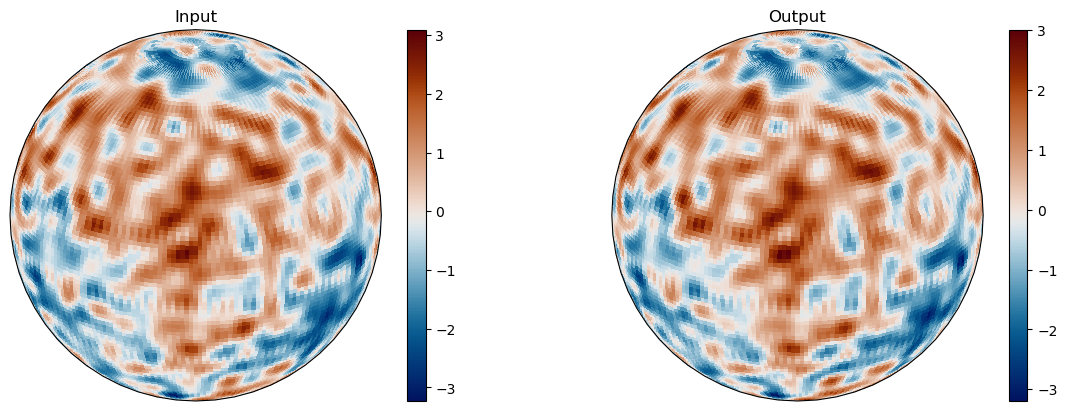

In [5]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,2, figsize = (12,4), subplot_kw={'projection': proj}, layout = "constrained")

# contour data over the map.
im = axs[0].pcolormesh(Lons, Lats, a[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[0].set_title("Input")

im = axs[1].pcolormesh(Lons, Lats, u[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[1].set_title("Output")

# Run Model

In [6]:
# Losses and parameters
l2loss = SphericalL2Loss(nlon = nlon, weights = weights.to(device))
energy_score = EnergyScore(type = "spherical", nlon = nlon, weights = weights.to(device))


# Training parameters
epochs = 5
learning_rate = 0.001
dropout_rate = 0.05
max_train = 1000

In [7]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
dropout_model = dropout_model.to(device)


n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 277923 parameters.


In [8]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate)

In [9]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    dropout_model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = dropout_model(a)
            test_l2 += l2loss(out, u).item()

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}, Test-L2-{:0.6f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-199.0899, Train-L2-0.177015, Test-L2-0.634444
Epoch-1, Time-86.5360, Train-L2-0.099309, Test-L2-0.267698
Epoch-2, Time-148.2379, Train-L2-0.046308, Test-L2-0.107917
Epoch-3, Time-35.0805, Train-L2-0.031980, Test-L2-0.087715
Epoch-4, Time-30.4230, Train-L2-0.027143, Test-L2-0.077765


# MCDropout

In [10]:
dropout_model.train()
""" Prediction """
mse_dropout = 0
es_dropout = 0
coverage_dropout = 0
int_width_dropout = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1), u).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test


print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.0786383643265482
ES: 0.05585108554127124


# Laplace approximation

In [11]:
la_model = LA_Wrapper(dropout_model, n_samples=n_samples, method = "last_layer", hessian_structure = "full", optimize = True)
la_model.fit(test_loader)

In [12]:
""" Prediction """
mse_la = 0
es_la = 0
coverage_la = 0
int_width_la = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = la_model.predictive_samples(a)
        mse_la += l2loss(out.mean(axis = -1), u).item() / n_test
        es_la += energy_score(out, u).item() / n_test


print('MSE:', mse_la)
print('ES:', es_la)

MSE: 0.07784344235392245
ES: 0.06321406876175784


# PFNO

In [13]:
hidden_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
hidden_model = hidden_model.to(device)


n_params = count_model_params(hidden_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

pfno_model = PNO_Wrapper(hidden_model, n_samples = 3)
pfno_model.to(device)

optimizer = torch.optim.Adam(pfno_model.parameters(),lr=learning_rate)


Our model has 277923 parameters.


In [14]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    pfno_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = pfno_model(a)
            test_l2 += energy_score(out,u)

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-155.9617, Train-L2-0.3039, Test-L2-0.0907
Epoch-1, Time-72.0104, Train-L2-0.0683, Test-L2-0.0615
Epoch-2, Time-71.1457, Train-L2-0.0510, Test-L2-0.0505
Epoch-3, Time-70.7251, Train-L2-0.0453, Test-L2-0.0474
Epoch-4, Time-70.4628, Train-L2-0.0420, Test-L2-0.0458


In [15]:
pfno_model.train()
""" Prediction """
mse_pfno = 0
es_pfno = 0
coverage_pfno = 0
int_width_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1), u).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)

MSE: 0.06284408640581368
ES: 0.04579042546849879


# Compare Metrics

In [21]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout}")
print(f"LA \nMSE: {mse_la} \t ES: {es_la}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno}")

Dropout 
MSE: 0.0786383643265482 	 ES: 0.05585108554127124
LA 
MSE: 0.07784344235392245 	 ES: 0.06321406876175784
PFNO 
MSE: 0.06284408640581368 	 ES: 0.04579042546849879


# Visualizations

In [22]:
n_samples = 100

In [26]:
samples = np.random.randint(0,n_test,3)

#fno_model.train()
dropout_model.train()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )
        truth.append( u )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()
truth = torch.cat(truth, dim = 0).cpu().numpy()

In [27]:
idx = 0
preds = [pred_dropout, pred_la, pred_pfno]

Text(0, 0.5, 'PFNO')

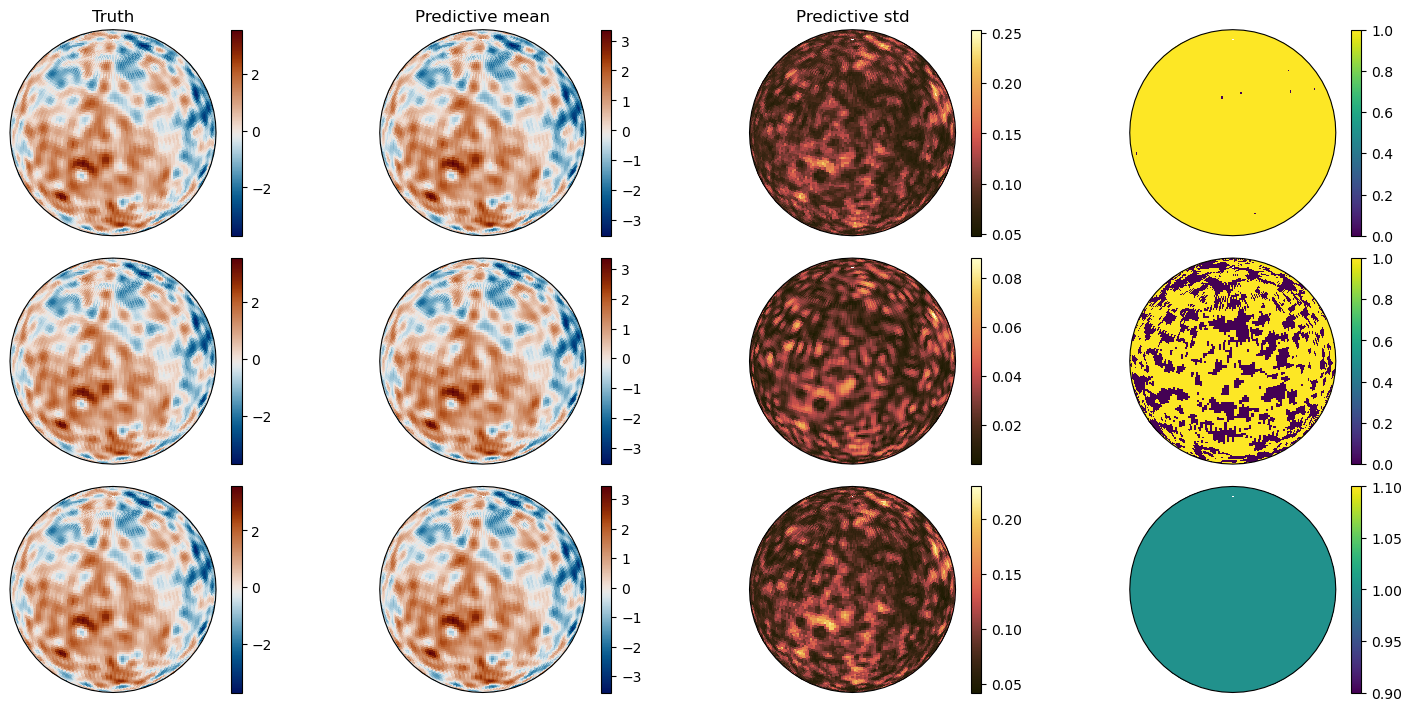

In [28]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,4, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].mean(axis = -1), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,2].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,3].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Truth")
axs[0,1].set_title("Predictive mean")
axs[0,2].set_title("Predictive std")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")